In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
!wget https://raw.githubusercontent.com/karpathy/makemore/refs/heads/master/names.txt
words = open('names.txt', 'r').read().splitlines()
words[:8]

--2025-02-05 18:38:24--  https://raw.githubusercontent.com/karpathy/makemore/refs/heads/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.005s  

2025-02-05 18:38:25 (46.2 MB/s) - ‘names.txt’ saved [228145/228145]



['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [3]:
#build the vocab of chars and mapping to and from ints
chars = sorted(list(set(''.join(words)))) # sorted list of all unique chars in dataset
stoi = {s:i+1 for i,s in enumerate(chars)} # string to int mapping
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()} # int to string mapping
print(itos)
vocab_size = len(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
#building the dataset
block_size = 3 # context length -> how many previous chars we are using to predict the next

def build_dataset(words):
  X, Y = [], []
  for w in words:
      #print(w)
      context = [0] * block_size
      for ch in w + '.':
          ix = stoi[ch]
          X.append(context)
          Y.append(ix)
          #print(''.join(itos[i] for i in context), '--->', itos[ix])
          context = context[1:] + [ix] # crop and append
  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2]) # dev == validation
Xte, Yte = build_dataset(words[n2:])


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [19]:
#mlp
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for repeducibility
C = torch.randn((vocab_size, n_embd),             generator=g) # 27 for amount of chars(fan_in), 10 for emedding demension of each char(fan_out)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01 # numbers are intiailly too high giving it a very high intitial loss but how do we get these scalars?
b2 = torch.randn(vocab_size,                       generator=g) * 0.0

# batch normilization gain and bias, they also get trained with the backprogpagation so they can shift around
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total

for p in parameters:
  p.requires_grad = True

6297


Maintaining Gaussian Distribution

- Unscaled Weights: If the weights in w were left unscaled (with a standard deviation of 1), the repeated summations in a deep neural network could lead to the activations (outputs of each layer) having very large or very small values. This can cause problems like vanishing or exploding gradients, making training difficult.
- Scaled Weights: By scaling the weights with 1/sqrt(n) (where n is the number of inputs to a neuron), the variance of the output y is kept in check. This helps ensure the activations remain roughly Gaussian, which leads to more stable training.

tensor(-0.0137) tensor(1.0039)
tensor(-0.0018) tensor(0.9923)


(array([2.25857750e-05, 4.51715501e-05, 6.77573251e-05, 9.03431001e-05,
        2.48443525e-04, 2.25857750e-04, 2.71029300e-04, 7.90502126e-04,
        1.73910468e-03, 2.64253568e-03, 4.17836838e-03, 6.12074503e-03,
        9.98291256e-03, 1.49743688e-02, 2.35343776e-02, 3.81699598e-02,
        5.78421699e-02, 8.25961793e-02, 1.18349461e-01, 1.62278794e-01,
        2.20188721e-01, 2.76653158e-01, 3.40119186e-01, 3.93737816e-01,
        4.26713048e-01, 4.39586939e-01, 4.11535407e-01, 3.58278149e-01,
        3.03010758e-01, 2.33920872e-01, 1.78246937e-01, 1.32826943e-01,
        9.54700711e-02, 6.40080864e-02, 4.27097006e-02, 2.72384447e-02,
        1.85880928e-02, 1.20382181e-02, 7.00159026e-03, 3.92992486e-03,
        2.50702103e-03, 1.58100425e-03, 9.71188326e-04, 7.22744801e-04,
        6.54987476e-04, 3.16200850e-04, 2.25857750e-04, 6.77573251e-05,
        9.03431001e-05, 4.51715501e-05]),
 array([-5.57278776, -5.35140948, -5.1300312 , -4.90865293, -4.68727465,
        -4.46589637, 

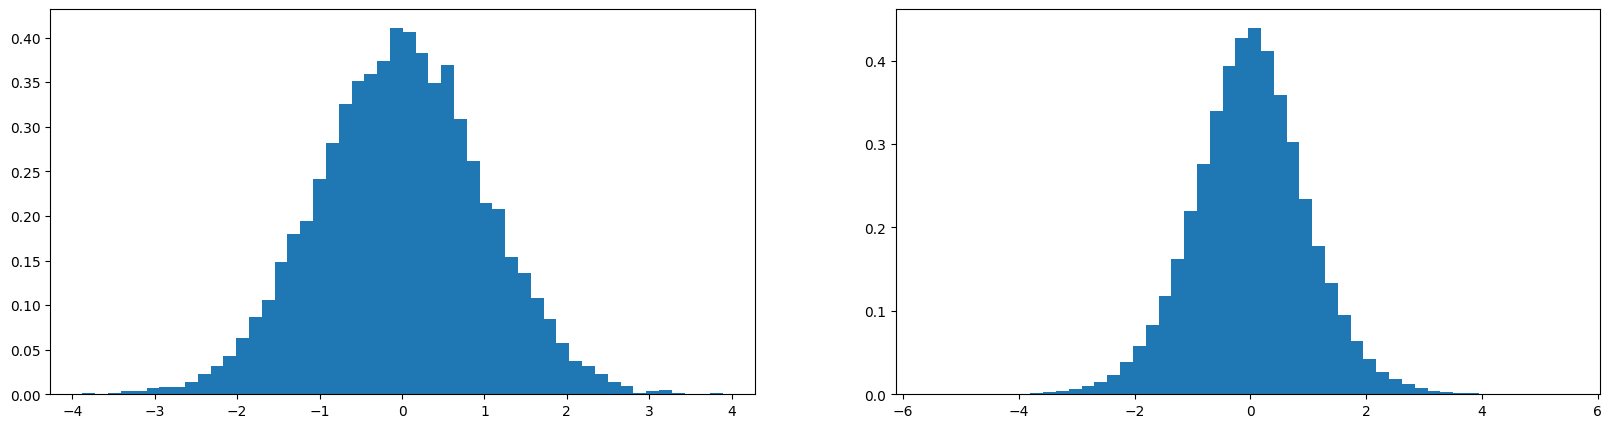

In [20]:
# we want to scale the Ws but keep them guassian like x
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / 10**.5 # this scalar keeps the answer guassion
y = x @ w #activations
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True)
#this stuff is prolly useless to know cuz of batch normilization

In [29]:
#optimization
max_steps = 200000
batch_size = 32
lossi = []


for i in range(max_steps):
  #minbatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,)) # using minibatches help us train faster
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X Y

  #forward pass/ weight layer
  emb = C[Xb] # (32, 3, 2)
  embcat = emb.view(emb.shape[0], -1) # concating emb
  hpreact = embcat @ W1 # + b1 #hidden later pre activation, u can skip all the fancy weight mulitplication stuff if you just make this guassian

  #batchnorm layer / normilization layer
  bnmeani = hpreact.mean(0, keepdim=True) # batch normilization mean
  bnstdi = hpreact.std(0, keepdim=True) # batch normilization std
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias # batch normilization

  with torch.no_grad(): #this just means the tensors will be updated outside of the gradient based optimization
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

  #non linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2  #output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  # set the gradients to zero
  for p in parameters:
    p.grad = None
  loss.backward() ## populate those gradients

  #update
  lr = .1 if max_steps < 100000 else .01
  for p in parameters:
    if p.grad is not None: # Check if gradient is calculated before updating
      p.data += -lr * p.grad #learning rate

  #track the loss
  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

  #break # for debugging

      0/ 200000: 2.1663
  10000/ 200000: 2.3773
  20000/ 200000: 2.3488
  30000/ 200000: 2.2330
  40000/ 200000: 2.2394
  50000/ 200000: 2.4625
  60000/ 200000: 2.3741
  70000/ 200000: 2.0293
  80000/ 200000: 1.9553
  90000/ 200000: 2.2501
 100000/ 200000: 2.2687
 110000/ 200000: 2.1205
 120000/ 200000: 2.0686
 130000/ 200000: 2.0037
 140000/ 200000: 2.1586
 150000/ 200000: 1.9256
 160000/ 200000: 2.1687
 170000/ 200000: 2.3713
 180000/ 200000: 2.3700
 190000/ 200000: 1.9482


**Batch normalization (BatchNorm)** is a technique used to normalize the activations within a neural network. Here's a simplified explanation of what it does:

- Calculates Mean and Standard Deviation: For each mini-batch of data, BatchNorm calculates the mean and standard deviation of the activations for each neuron.
- Centers and Scales: It then centers the activations by subtracting the mean and scales them by dividing by the standard deviation. This ensures that the activations have a mean of 0 and a standard deviation of 1.

- Learnable Parameters: BatchNorm also introduces two learnable parameters, often called gamma and beta(bngain and bnbias), which allow the network to further shift and scale the normalized activations.
Redundancy of Biases

Now, consider the role of a bias in a typical neural network layer:

- Shifting Activation: A bias term is added to the weighted sum of inputs to shift the activation function. This allows the neuron to activate even when the weighted sum is zero.
- However, when using BatchNorm, the centering step already shifts the activations to have a mean of 0. This essentially performs a similar function to a bias term.

Why the redundancy?

- BatchNorm's centering: Since BatchNorm centers the activations by subtracting the mean, adding a bias before BatchNorm would simply be canceled out during the centering process.
- **Learnable** Parameters: BatchNorm's learnable parameters (gamma and beta) provide the flexibility to further shift and scale the activations, effectively incorporating the functionality of a bias.

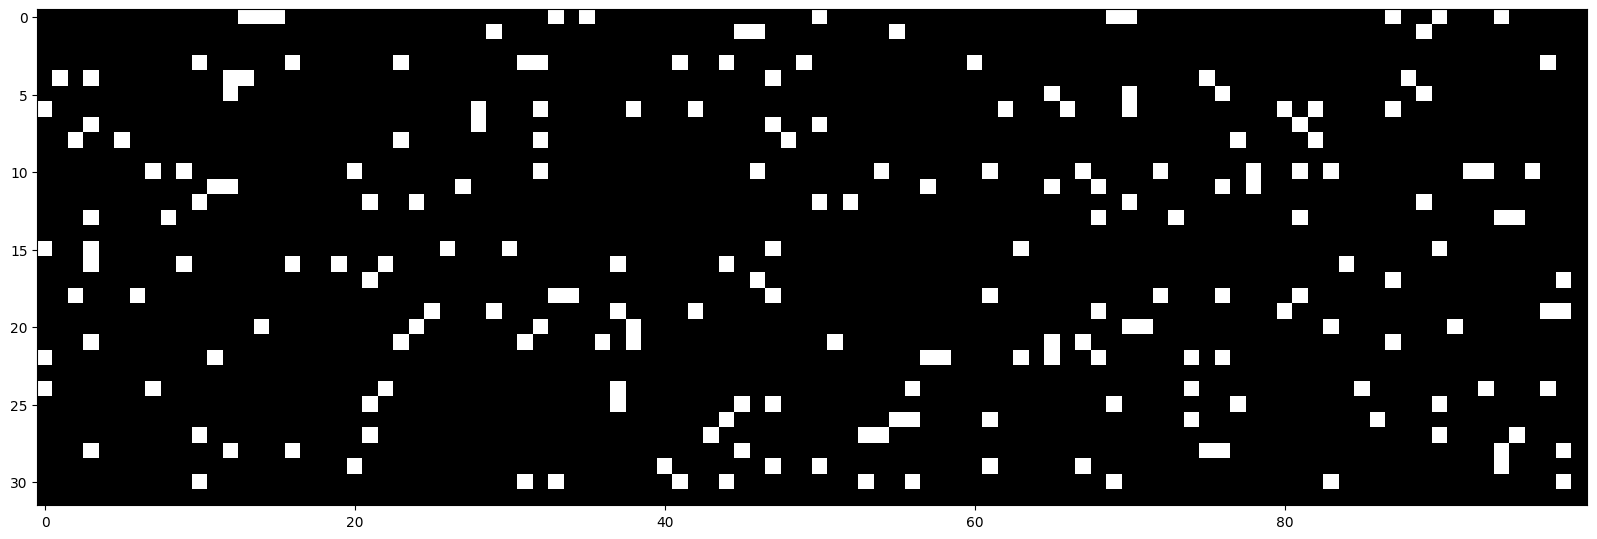

In [30]:
plt.figure(figsize=(20,10)) # white spots are the parts of the nueron that get destroyed bc of the tanh(which is an activation function), if whole coloumn was white the nueron would be completely dead(it cant learn and all its gradients are zero)
plt.imshow(h.abs() > .99, cmap='gray', interpolation='nearest')

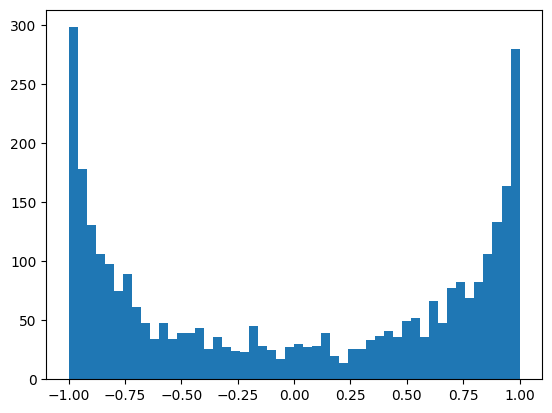

In [31]:
plt.hist(h.view(-1).tolist(), 50); # it is bad when it is saturated at -1 or 1 cuz it messes up the tanh(the 1 or neg 1 kills the gradient)

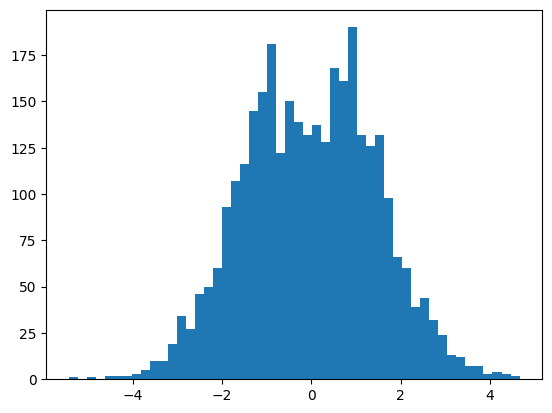

In [32]:
plt.hist(hpreact.view(-1).tolist(), 50);

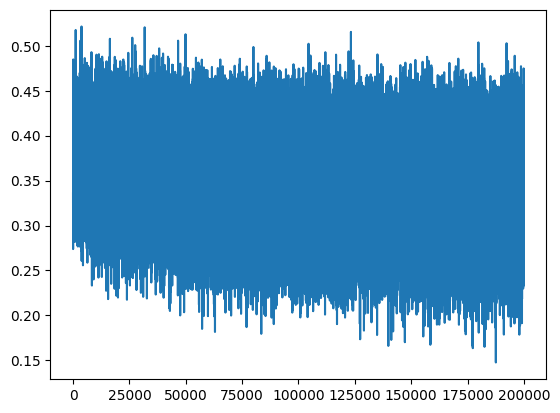

In [33]:
plt.plot(lossi) # works after full optimization

In [34]:
# calibraete the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  # measure the mean/standard div iver the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)
  # normalize the values


In [35]:
@torch.no_grad() # decorator that disables gradient tracking
def split_loss(split):
  x, y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias # batch normilization layer
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')


train 2.1643011569976807
val 2.180652618408203


**TakeAways**
- If you have too confidenent mispredictions by the model, bc of a messed up activations at lasst layers during training you end up with a hocky stick loss. But if you fix this you get a better loss at the end bc you can skip over the time wasted with confident mispreditions
- You also want to control the activations b/c if they are too saturated around 1 or 0 the tanh/nonlinear layer messes them up, So you want roughly guassian activations through the nueral net
- We can normilize batches at a time to maintain a guassian distriubution throughout the activations however this works less and less with bigger/deeper neural nets.
- Normilization layers are like batch norm can be sprinkled thorughout the neural net to get more guassian activations, batch norm does this by getting the mean and the standard dev of the activations and using them to center your data, it also uses trained bn weights and biases to shift the normilization as needed.

In [36]:
#sampling from the model
block_size = 3
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
  out = []
  context = [0] * block_size # initialize with all
  while True:
    emb = C[torch.tensor([context])]# (1, block_size, d)
    h = torch.tanh(emb.view(1,-1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1, generator=g).item() # samples from the probabilitys to get the nxt index/char
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break

  print(''.join(itos[i] for i in out))

mridgymyannigengh.
hryah.
methangengrlig.
mderydgelin.
mminne.
jakelshan.
marvelyzimslyannn.
shdbergyaghinsthindreth.
jhxnthucfoubngycder.
juduf.
mhshric.
mustlydh.
hil.
sadyannyn.
zakhlrenne.
jurb.
wivevosgynfaddrfennoh.
bhgrpeilah.
muthya.
hmrerlynn.


-----------------------------------
PYTORCHIFYING THIS SHI
-----------------------------------

In [15]:
#time to train a deeper nueral net

#same as pytorch
class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn(fan_in, fan_out)
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    #paramters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    #buffers ( runnning count )
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)


  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch var
    else:
      xmean = self.running_mean
      xvar = self.running
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd), generator=g)
layers= [
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size), BatchNorm1d(vocab_size),
]

with torch.no_grad():
  # last layer: make less confident/reduce hockey puck loss
  layers[-1].gamma *= 0.1
  # all other layer apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))# number of total parameters
for p in parameters:
  p.requires_grad = True

47451


In [16]:
# same optimization

max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  #construct minibatch
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix]

  #forward pass
  emb = C[Xb] #embed the chars into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function

  #backward pass
  for layer in layers:
    layer.out.retain_grad() # we take our the retain grad after debugging
  for p in parameters:
    p.grad = None
  loss.backward()

  #update
  lr = 0.1 if i < 100000 else 0.01 # step learniing decay rate
  for p in parameters:
    p.data += -lr * p.grad

  #track the stats
  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  break

      0/ 200000: 3.3071


layer 1 (      Tanh): mean -0.01, std 0.95, saturated: 80.97%
layer 3 (      Tanh): mean +0.03, std 0.97, saturated: 89.16%
layer 5 (      Tanh): mean +0.00, std 0.97, saturated: 89.22%
layer 7 (      Tanh): mean -0.01, std 0.98, saturated: 89.81%
layer 9 (      Tanh): mean -0.00, std 0.97, saturated: 88.94%


Text(0.5, 1.0, 'activations distributions')

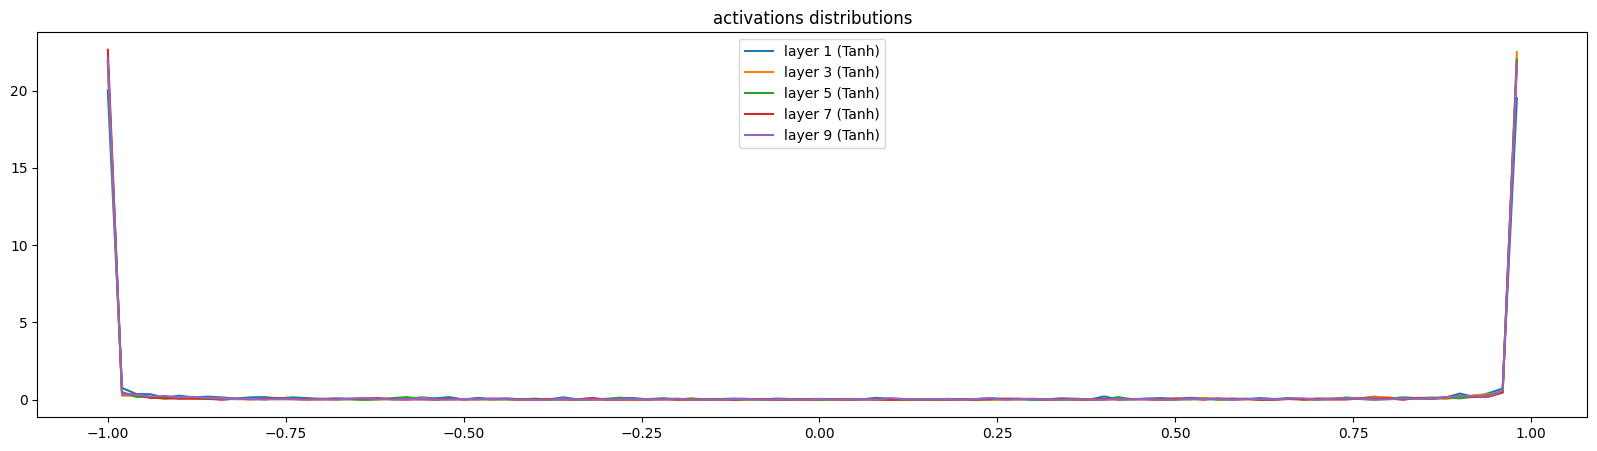

In [14]:
# visualize histograms
plt.figure(figsize=(20, 5))# width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): #excluding the outside layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy,hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('activations distributions')